<a href="https://colab.research.google.com/github/sbalram123/CoronaBatch-Session4/blob/master/SB_CoronaBatch_A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
  %matplotlib inline

In [95]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"
import torch
import torchvision
import torchvision.transforms as transforms
import albumentations.augmentations.transforms as al_transforms

# CoronaBatch : Sangeeta, Monish, Ashish, Ashwin

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-hv9tefyw
All libraries are successfully installed!


In [96]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)



classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



 deer   car  frog  ship


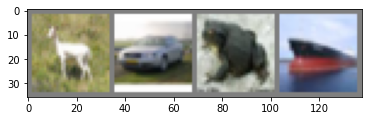

In [97]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#Adding Horizontal Flip from Albumentation only to Train dataset

# always_apply=False, p=0.5
al_transforms.HorizontalFlip(images)


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))




In [0]:
    def get_data_loader(self, train, test, batch_size=128):
        SEED = 1
        # CUDA?
        cuda = torch.cuda.is_available()
        print("CUDA Available?", cuda)

        # For reproducibility
        torch.manual_seed(SEED)

        if cuda:
            torch.cuda.manual_seed(SEED)

        # dataloader arguments - something you'll fetch these from cmdprmt
        dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

        # train dataloader
        train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

        # test dataloader
        test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
        return train_loader, test_loader

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [0]:
  # return nn.Sequential(nn.Conv2d(nin, nin * kernels_per_layer, kernel_size=3, padding=1, groups=nin),
  #                       nn.Conv2d(nin * kernels_per_layer, nout, kernel_size=1),
  #                       nn.ReLU(),            
  #                       nn.BatchNorm2d(nout),
  #                       nn.Dropout(dropout))



import torch.nn as nn
import torch.nn.functional as F

dropout = 0.09 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()       
        self.model = nn.Sequential(
                                nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding= 0, bias= False, dilation = 2),
                                nn.ReLU(),            
                                nn.BatchNorm2d(32),
                                nn.Dropout(dropout),

                                # Depthwize Convolution Code Starts *************************
                                nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32),
                                nn.Conv2d(32, 64, kernel_size=1, padding=1),
                                nn.ReLU(),            
                                nn.BatchNorm2d(64),
                                nn.Dropout(dropout),
                                # Depthwize Convolution Code Ends ***************************

                                nn.MaxPool2d(2,2),

                                # Depthwize Convolution Code Starts *************************
                                nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64),
                                nn.Conv2d(64, 128, kernel_size=1, padding=1),
                                nn.ReLU(),            
                                nn.BatchNorm2d(128),
                                nn.Dropout(dropout),
                                # Depthwize Convolution Code Ends ***************************

                                nn.MaxPool2d(2,2),

                                # Depthwize Convolution Code Starts *************************
                                nn.Conv2d(128, 128, kernel_size=3, padding=1, groups=128),
                                nn.Conv2d(128, 128, kernel_size=1),
                                nn.ReLU(),            
                                nn.BatchNorm2d(128),
                                nn.Dropout(dropout),
                                # Depthwize Convolution Code Ends *************************

                                nn.MaxPool2d(2,2),

                                # Depthwize Convolution Code Starts *************************
                                nn.Conv2d(128, 128, kernel_size=3, padding=1, groups=128),
                                nn.Conv2d(128, 470, kernel_size=1),
                                nn.ReLU(),            
                                nn.BatchNorm2d(470),
                                nn.Dropout(dropout),
                                # Depthwize Convolution Code Ends *************************

                                nn.AvgPool2d(kernel_size= 3),
                                nn.Conv2d(in_channels=470, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),                        
                                )
    
    def forward(self,x):
      x = self.model(x)
      x=x.view(-1,10)
      return F.log_softmax(x, dim= -1)


net = Net()

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [101]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             864
              ReLU-2           [-1, 32, 28, 28]               0
       BatchNorm2d-3           [-1, 32, 28, 28]              64
           Dropout-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 32, 28, 28]             320
            Conv2d-6           [-1, 64, 30, 30]           2,112
              ReLU-7           [-1, 64, 30, 30]               0
       BatchNorm2d-8           [-1, 64, 30, 30]             128
           Dropout-9           [-1, 64, 30, 30]               0
        MaxPool2d-10           [-1, 64, 15, 15]               0
           Conv2d-11           [-1, 64, 15, 15]             640
           Conv2d-12          [-1, 128, 17, 17]           8,320
             ReLU-13          [-1, 128, 17, 17]               0
      BatchNorm2d-14          [-1,

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [102]:
for epoch in range(39):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.831
[1,  4000] loss: 1.597
[1,  6000] loss: 1.471
[1,  8000] loss: 1.355
[1, 10000] loss: 1.282
[1, 12000] loss: 1.250
[2,  2000] loss: 1.166
[2,  4000] loss: 1.129
[2,  6000] loss: 1.101
[2,  8000] loss: 1.088
[2, 10000] loss: 1.055
[2, 12000] loss: 1.042
[3,  2000] loss: 0.958
[3,  4000] loss: 0.967
[3,  6000] loss: 0.956
[3,  8000] loss: 0.949
[3, 10000] loss: 0.937
[3, 12000] loss: 0.947
[4,  2000] loss: 0.894
[4,  4000] loss: 0.871
[4,  6000] loss: 0.864
[4,  8000] loss: 0.882
[4, 10000] loss: 0.857
[4, 12000] loss: 0.847
[5,  2000] loss: 0.788
[5,  4000] loss: 0.814
[5,  6000] loss: 0.828
[5,  8000] loss: 0.800
[5, 10000] loss: 0.799
[5, 12000] loss: 0.797
[6,  2000] loss: 0.743
[6,  4000] loss: 0.761
[6,  6000] loss: 0.764
[6,  8000] loss: 0.752
[6, 10000] loss: 0.743
[6, 12000] loss: 0.769
[7,  2000] loss: 0.708
[7,  4000] loss: 0.727
[7,  6000] loss: 0.726
[7,  8000] loss: 0.696
[7, 10000] loss: 0.722
[7, 12000] loss: 0.709
[8,  2000] loss: 0.676
[8,  4000] 

KeyboardInterrupt: ignored

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


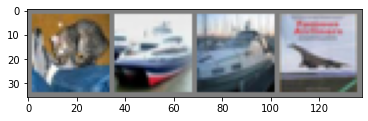

In [103]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [105]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [106]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 77 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [107]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 81 %
Accuracy of   car : 87 %
Accuracy of  bird : 70 %
Accuracy of   cat : 62 %
Accuracy of  deer : 72 %
Accuracy of   dog : 66 %
Accuracy of  frog : 82 %
Accuracy of horse : 80 %
Accuracy of  ship : 84 %
Accuracy of truck : 83 %


In [108]:
#Adding Module for GradCam to resnet18
!pip install pytorch-gradcam


In [0]:
import torchvision.models as models
from gradcam import *

In [0]:
#GradCAM Module

class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam
      

In [0]:

import argparse

def preprocess_image(img):
    means = [0.5, 0.5, 0.5]
    stds = [0.5, 0.5, 0.5]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input


def get_args():
    parser = argparse.ArgumentParser()
    #parser.add_argument('--use-cuda', action='store_true', default=False,
    #                    help='Use NVIDIA GPU acceleration')
    #parser.add_argument('--image-path', type=str, default='./examples/both.png',
    #                    help='Input image path')
    args = parser.parse_args()
    args.use_cuda = args.use_cuda and torch.cuda.is_available()
    if args.use_cuda:
        print("Using GPU for acceleration")
    else:
        print("Using CPU for computation")

    return args

In [0]:
# Can work with any model, but it assumes that the model has a
# feature method, and a classifier method,
# as in the VGG models in torchvision.

#Running GradCAM on Resnet18 model

args = get_args()
model = models.resnet18(pretrained=True)
grad_cam = GradCam(model=model, feature_module=model.layer4, \
                       target_layer_names=["2"], use_cuda=args.use_cuda)
img, _ = next(iter(trainloader))
input = preprocess_image(img)

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.
target_index = None
mask = grad_cam(input, target_index)

show_cam_on_image(img, mask)